# Signal modelling and source separation - GSMM models

This notebook trains signal models and performs source separation for multiple signals.

The signal model is given as
$$ To appear soon (hopefully) $$

The observation model is given as
$$ p(y_k \mid x^{1:N}_k) = \mathcal{N}\left(y_k \mid \sum_{n=1}^N x^n_k, \ \gamma_y^{-1}\right)$$



## Load packages

In [1]:
import Pkg; Pkg.activate("C:/Users/s151781/AppData/Local/Julia-1.3.1/GN/Project.toml")
using Revise
using FFTW
using Compat
using WAV
using DSP
using Base64
using ForneyLab
using LinearAlgebra
using ProgressMeter
using PyPlot
using GaussianMixtures
using Random
using Printf
using BenchmarkTools
using HDF5
;

Activating environment at `C:\Users\s151781\AppData\Local\Julia-1.3.1\GN\Project.toml`


In [2]:
include("../extensions/ComplexNormal.jl")
include("../extensions/ComplexHGF.jl")
include("../extensions/ComplexToReal.jl")

include("../functions/auxiliary/workflow.jl") 
include("../functions/auxiliary/fourier.jl") 
include("../functions/auxiliary/audioplayer.jl")
include("../functions/auxiliary/visualization.jl")
include("../functions/preprocessing.jl") 
;

## Parameters

In [25]:
# signal definition
sound_files = ["../data/woman.wav",            # specify sound sources to model and separate (can be more than 2)
               "../data/obama.wav"]
fs_desired = 8000                              # specify desired sampling frequency of signals
duration_train = 3                             # specify duration of training signals
duration_sep = 5                               # specify duration of mixture signal
normalization_method = "max"                   # specify method to use for normalizing the signals

# save folders
folder_params = "inferred/GSMM_model"          # specify folder to save inferred values in (to save time when recomputing)
folder_figures = "figures/GSMM_model"          # specify folder to save figures in
folder_audio = "audio/GSMM_model"              # specify folder to save audio in

# inference and modelling
nr_clusters = [13,7]                           # number of clusters in GSMM (if you want to use 2 orders: see footnote below notebook)
nr_freqs = 24                                  # number of frequencies in log-power domain (excluding DC and fs/2)
overlap_train = 0.5                            # portion of overlap during training
overlap_sep = 0.0                              # portion of overlap during source separation
iterations = 10                                # number of iterations for variational message passing
Σ_meas_train = 1e-5                            # assumed precision of measurement noise during training
Σ_meas_sep = 1e-4                              # assumed precision of measurement noise during source separation
window=rectangularwindow                       # specify windowing function
;

In [4]:
# auxiliary variables
bufsize = 2*(nr_freqs+1)                                                             # size of time-domain buffer
stepsize_train = Int(round(bufsize*(1-overlap_train)))                               # stepsize during training
stepsize_sep = Int(round(bufsize*(1-overlap_sep)))                                   # stepsize during source separation
nr_samples_train = Int((fs_desired*duration_train-bufsize)/stepsize_train) + 1       # number of samples during training
nr_samples_sep = Int((fs_desired*duration_sep-bufsize)/stepsize_sep) + 1             # number of samples during source separation
freqs = abs.(FFTW.fftfreq(bufsize)[1:nr_freqs+2]*fs_desired)[2:end-1]                # frequencies of probabilistic Fourier transform
;

## Load and preprocess data

In [5]:
# create array for time signals and log-power signals
signal = Array{Array{Float64,1},1}(undef, length(sound_files))
signal_sep = Array{Array{Float64,1},1}(undef, length(sound_files))
signal_z = Array{Array{Float64,2},1}(undef, length(sound_files))
signal_sep_z = Array{Array{Float64,2},1}(undef, length(sound_files))

# load signals, preprocess, crop and save
for k = 1:length(sound_files)
    
    # load signal
    signal_tmp, fs_tmp = wavread(sound_files[k], format="native")
    fs_tmp = Int(fs_tmp)
    signal_tmp = Float64.(signal_tmp)
    
    # crop signal
    signal_tmp = signal_tmp[1*fs_tmp+1:(1+duration_train)*fs_tmp]
    
    # preprocess signal and save
    signal[k] = preprocess(signal_tmp, fs_tmp, fs_desired=fs_desired, normalization_method=normalization_method)
    
    # take windowed fft of signal
    signal_tmp = FFTovertime(signal[k], bufsize, bufsize-stepsize_train, window)

    # reduce fft
    signal_tmp =  hcat(real.(signal_tmp[:,1]), 2*real.(signal_tmp[:,2:nr_freqs+1]), real.(signal_tmp[:,nr_freqs+2]), -real.(signal_tmp[:,1]), -2*imag.(signal_tmp[:,2:nr_freqs+1]), imag.(signal_tmp[:,nr_freqs+2]))

    # get the log abs values
    signal_z[k] = log.(abs2.(signal_tmp[:,2:nr_freqs+1]) + abs2.(signal_tmp[:,nr_freqs+4:end-1]))
        
end

# create mixture signal 
ymix = zeros(bufsize*nr_samples_sep)
for k = 1:length(sound_files)
    
    # load signal
    signal_tmp, fs_tmp = wavread(sound_files[k], format="native")
    fs_tmp = Int(fs_tmp)
    signal_tmp = Float64.(signal_tmp)
    
    # crop signal
    signal_tmp = signal_tmp[1*fs_tmp+1:(1+duration_sep)*fs_tmp]
    
    # preprocess signal and save
    signal_sep[k] = preprocess(signal_tmp, fs_tmp, fs_desired=fs_desired, normalization_method=normalization_method)
    
    # take windowed fft of signal
    signal_tmp = FFTovertime(signal_sep[k], bufsize, bufsize-stepsize_sep, window)

    # reduce fft
    signal_tmp =  hcat(real.(signal_tmp[:,1]), 2*real.(signal_tmp[:,2:nr_freqs+1]), real.(signal_tmp[:,nr_freqs+2]), -real.(signal_tmp[:,1]), -2*imag.(signal_tmp[:,2:nr_freqs+1]), imag.(signal_tmp[:,nr_freqs+2]))

    # get the log abs values
    signal_sep_z[k] = log.(abs2.(signal_tmp[:,2:nr_freqs+1]) + abs2.(signal_tmp[:,nr_freqs+4:end-1]))
    
    # preprocess signal and save
    ymix = ymix + signal_sep[k]

end

# calculate low-power spectrum of mixture signal
zmix = FFTovertime(ymix, bufsize, bufsize-stepsize_sep, window)
zmix =  hcat(real.(zmix[:,1]), 2*real.(zmix[:,2:nr_freqs+1]), real.(zmix[:,nr_freqs+2]), -real.(zmix[:,1]), -2*imag.(zmix[:,2:nr_freqs+1]), imag.(zmix[:,nr_freqs+2]))
zmix = log.(abs2.(zmix[:,2:nr_freqs+1]) + abs2.(zmix[:,nr_freqs+4:end-1]))

# create time axis
t_train = collect(1:length(signal[1]))/fs_desired
t_sep = collect(1:length(ymix))/fs_desired
;

## Visualise signals

<source src="data:audio/wav;base64,UklGRjx3AQBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQB3AQDeGCG+wHJcvpCsGr6ixAK+A3W1vZxHMLwrUcM98JIxPuc6hz4v4rA+unPDPsMfuD4Q3bE+DGdePvco9Tx16ju9Ir4bvXWXJL4aCpa+tNl5vqmb4L2Bf5C9G/98vfNcALo0wpA9ATiNPR/00zxiisy886Wdvb5dwr0tT/+9tnYzviMdWb4ejzG+b/r3vV/vwr2bX4K9rMM4PadMMj4bDYM+MZedPu+jvT7ttcM+jtK7Ph2Fez5VY3M9UpMjvZUQIb2Qxxq+6x2avjUQkb7yfhG+ny2WvXbAs70FmBe9eiN3PQPkuD39k189g9SXPG67zrzW/5K9eYDmvdo4GL4uKk6+HcdIvrpwHL4rqei9V3aCvSDOcT19yk8+phiSPm2xqz6Nn8s+MBjWPjzBpD4jDuM9kcpPPNEtWjkJ7OW9LSaevrQCqr6Cnkm+mnX/vV/uFr7MH9W9c9gePd35Az4HYL49mRf1PCwOpTzvFSA9dVHPvPGsDr7cG0i+X2wvvhQCHb5DcB2+tLj9vRKY4bsisQw+g9h1PuGgkT5LWa8+Pl7PPqpdvT7+YkY+O86qPGk40juD1PS8IzphvlGRuL5lDYq+Gk8lvrzPKL4kTya+dqpZvXeGTD1ZXKE9IhJiPZqXqTxSzMs7Uhe7PM820LzfzAm+ljgfvnlrmr3hRCS9CbQxvQ2PlT2ij4U+cpywPveHsD5RtbI+UZluPrSN0j3Pe5M9C3JNvDMncb7zT6G+YONevpqsPr4fGXG+IAU1viAbsbzr55M9i5LJPQ+T/j0JjMk9huyCPcfRjD0ShN48dkD1vWc5Vr59Dh2+L+EKvgp1Wr5bmki+SwFUvVNzRT245Yg930cFPiLVYT5CK4Y+pSBpPivyPj5FPxY+3YHIPVP+Az04wyW9RB93vUgvhL2/SPq95mkwvqan/r0la629h/zVvU5dyL1ujJC8yzl/PKJbxLwX0k29CxEZvXHXvryl5cC8fBRzvPu3mTyj1cc9kSZEPnHygz49N5g+Pa62PqyKoD6zGMQ95g91vNK5ED1pm3u9FQegvndCpr48thO+7A4FviuEa75WfQi+KsqRPehfDz73VtU9yoIGPm5/Pj6VQTk+ScHsPdv1rjxahWG9jWS/vdhl2L3oNii+YDBQvpVBIb5ED5e9aoR8vQspYb2qbX85tTmFPVQ2gD1ZFxo9rF0ZPXOVHj3I7RE8SSgrvbM9Vb08pRG9mwruvKUKJb3g5Rq940HevMTEDLsdyRg8EixtO9Er1Lu7p/07gelPPDHzErxTOA29dNvcvNyUDbxieaa8Pi46vFhcmDz0IBQ9hJkLPU0/QT09nnE9JeiHPfkRXT3jDxU9SbvKPKwrnzzhdUE7dmUMvUG/R73DkD+9y9BrvfZVob1jZ4m93S9VvZUVVb18/k29miz6vHgcpLwA2Ja84hvVu+kH/ztvHX08nKn7PFvGcT3mkoc9aeGMPU9cvD1Xgdk9C326PUxVkD0qqEk959oIPTMvUrthYzK9Nai0vVPo7L2uOvq9QjT6vT3ADb664wa+EcK8vX8Pir1FpV69GHXvvAu4IzpBx5g8X6cZPa5MST0VRXs9WHfGPQ38DT4TSSY+lvU+PlZ3RD5LAR4+w3S8PZpbiz0HfoS7IuPgvRgBJL6kpB++e5xBvsoMcr5lYEy+WesHvk+g5r0cK9G9WU4nvVu4jTw/qgo9nbhFPa/xpD1VKt495enwPceYDz4R6Do+U+piPocTdT4C6zA+LoZYPUjNAj11a1w9lxNgvUkOS758vBq+lBmQvQ8SHb5LAFC+MEqtvcGEvTuufx69+eKYvK2HqT0Rbdw9rtZpPSJ+bT3q8KQ9FtgGPQEhBL3g0Be9JHcgvdMypr18Es69Dbe1vdVupL2Tn5O9aJNdve6P8ryl+Ue85dxtvJ4rO7zsvo86hkmLPGfggDvfICu8rWqVO9o5GDw1Uiy8/oUdvEur/jsBg8S7TbedvC5Pa7w0Mxq8E+YbvAinobv4s4k7gyreO6heFTwlLS08PfBiPF/qDz1+LRw953C+PDJmkTzAtQM9eiXrPD72gTx+uLY8+YbHPO1OBDysghu6eBhTOVHe6LsIhhC8XfgYvMHcB7z/TQu80WgLvHkDLbqhSyW7aAEWO8Gz/Tv307I7ENtYPJ2vvzwwpEk8cKVwPJW49TzzeKc8TJOyO1qchTwWe+48QMeJPLBECjzdQPA70AsYupKyHDy2now8XYsRvBHVL7w14lk8DC0wPDOkB7xtwyw7Ave+O4nQijoQRx88te/YO2TsNzoII+47eLqIPOv9Ejx36gU7kpNqPCjMADwo7Ks81vk7PL4oTTqxEgA9CyWEPD+1GTx8w9c8QIx6Owt4bDq2t8U8DPlBPEFjkryEA8q7EVItOT5cdrzFcRm7dUu9OjJGObxfxSg8MRrNu2l28Lxz7Yc8CAAAPTeKkry5ViK9gOpWPAyQEz0SK/W8m1fDvI2iHT2Ht6e86FgDvS9SJT3SpiO7Jh1zvdXmZzuoNqY8Q08Uvb3rJ73msqK7LyM1vOOq0LxKA/e7yXrhvFIbcLx5GLU8IpyOvCD+Rr0uA4s8ogw2POFFFb0IIE287JPSO/8HNbyrwcO8Q0mau6UKPTsOLde8pWCzvEfH0rtb6+O7OIHQvOJXwLy9Evu7KypjvMuzM7wr1/C7M50Lu7Bv4bqa8le7v3Rfu5GTfTpEv4A7mQ7LuziLjbsbq1W6ND95urs1XbtQghe8iW2mu9KYuLslp564bQnJOstdNjrMlNI5vbPVOzW5Ljrxoqe7DHUQu1oA0buNvCi8S8ksvHsKC7yPlim89PGDvPXGOrw3EuW7bwPCugBRfLvQ1kw6o2wsPGP7HzwokZA7cvPROzsrCzwE3nI7EWJAO2q7RTsJyIg4JAuQOpbio7gNo4W6jOu3uiU6z7q/9hc77AL6OWy8tLvuyr27amr2u4R0CLyeYwq8VS32u0VV7bqbbmY6HEq1Oyb1/Tq+iII6z7n4O5VsDjzo9Dk7zZQXukxDvju/oMk7nezZuvlIdLk+D8s7iaLFO6PVHTqyRF86+Q7MO0FO0Tvd5go8L8YePHWXSzzM7iQ8cx09PCxRGzxEjfk7a70TPJIssztcXh87jGrQOxmkzDvgYjY8qcEePJys4DtJeAQ83YgBPLMx3zvnZsQ7Lz4RPL/xQjylhNg7OXmmO4yEFjzrqfY75sokPEIIgjz3IFg8FNIUPH4DJjzyciQ8zrg3OwJ91DusQok6PC+kuz364rsf+9K7BGN9uzFXvLsrCpk50diSO5Gh7TpVY4I6MX83O4W95Tr86G67nr7Vu3DzD7wZDiq8bDsovCP1b7znjY68s0KJvItIeLz/gJy89RR1vEECVbzK4YK8muiFvOcXhbxjeYe8Z1WovHutm7xSbK+8gKyvvNkcqrzFRJ68ReGsvC6xorz5xTa8i8WCvIMEfbyFSFW8y1pHvJ/0SLyXoZq8GmudvH3OpbzYEom84gt+vDzagbxlKX684VlsvJlSgbwoEpG817WMvM94QLwROVe8OjF7vHmaPrxxvA28bXQovEn+0rv6j5u7qO4ovNUdF7xz5Ke7W86Au81Yf7su36K7qXzHuw+EJrfTitO6bfq5uTWZzDpJppI62qR4O2LfDDtCO6Y6O8iSO8GK4LrDTI+7QfPHOpu/OzqKXhE7Tz6nOoT52DvjTbU74uOMO9gvETzT7yc8g6ASPLuxfDzFeDw83kw2PGHvJTxN+RU8DYo6PHmgADwCvUo8BhAaPPgc7Tv7dgA8M+ZPPNzmQTyWYBo8WKJmPL0iZjxU3ws8c1YyPKAmYjyOm4E8MnKFPJUvfDyukGg8t7aEPPR3nDwtSGg8u0E2PL4lajz3Y

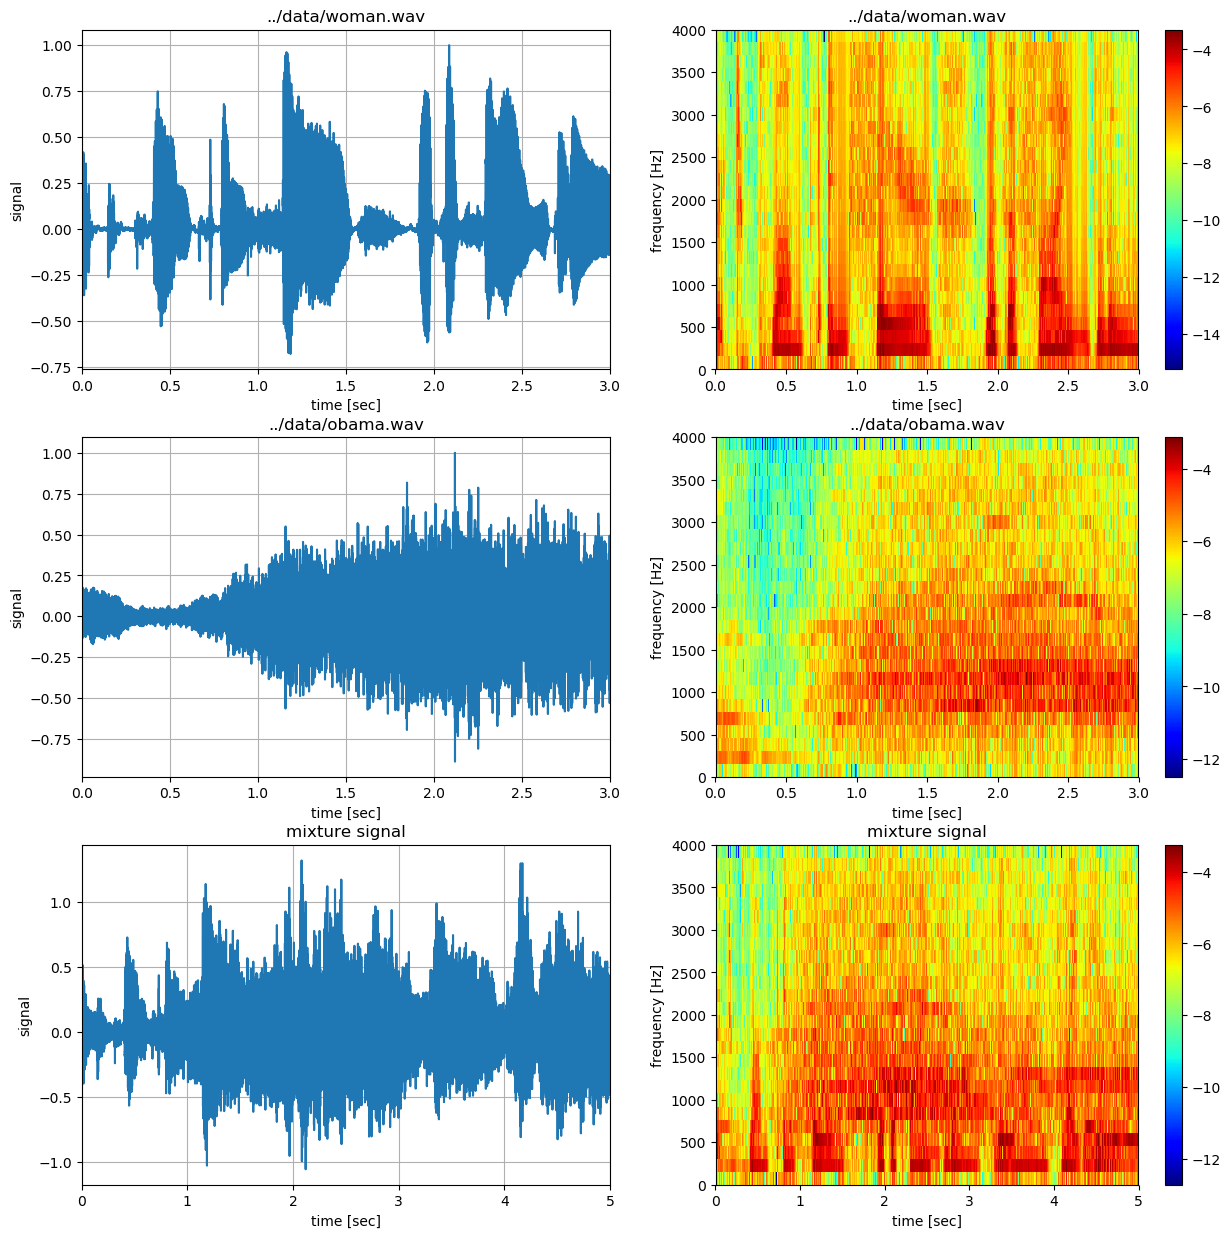

In [6]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files)+1, figsize=(15, 5*(length(sound_files)+1)))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot time-domain signal
    ax[k,1].plot(t_train, signal[k]), ax[k,1].set_xlim([0, duration_train]), ax[k,1].set_xlabel("time [sec]"), ax[k,1].set_ylabel("signal"), ax[k,1].grid(), ax[k,1].set_title(sound_files[k])
    
    # plot spectrogram of signal
    plot_spectrogram(spectrogram(signal[k], bufsize, bufsize-stepsize_train, fs=fs_desired), fs_desired, ax=ax[k,2], colorbar=true), ax[k,2].set_title(sound_files[k])

end

# finally add mixture signals
ax[end,1].plot(t_sep, ymix), ax[end,1].set_xlim([0, duration_sep]), ax[end,1].set_xlabel("time [sec]"), ax[end,1].set_ylabel("signal"), ax[end,1].grid(), ax[end,1].set_title("mixture signal")
plot_spectrogram(spectrogram(ymix, bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=ax[end,2], colorbar=true), ax[end,2].set_title("mixture signal")

# create audioplayers
audioplayers(signal..., ymix, fs=fs_desired)
;

## Define signal model

In [7]:
# create expression that can draw an entire graph in a factor graph statement
function signal_model(k, nr_clusters, nr_freqs, bufsize)
    
    # wrap code into an expression to execute later on in a factor graph type to allow for modularity
    model = quote
        
        # create dictionary for variables
        if !@isdefined vars
            vars = Dict()
        end
        
        # create mixture components
        for ki = 1:($nr_clusters)

            # specify distribution over precision matrix
            @RV vars[pad(pad(:w,ki),$k)] ~ Wishart(placeholder(pad(pad(:V_w,ki),$k), dims=($nr_freqs,$nr_freqs)), placeholder(pad(pad(:nu_w,ki),$k)))

            # specify distribution over mean
            @RV vars[pad(pad(:m,ki),$k)] ~ GaussianMeanPrecision(placeholder(pad(pad(:μ_m,ki),$k), dims=($nr_freqs,)), vars[pad(pad(:w,ki),$k)])

        end

        # specify distribution over categorical distribution
        @RV vars[pad(:π,$k)] ~ Dirichlet(placeholder(pad(:α_π,$k), dims=($nr_clusters,)))

        # specify distribution over selection variable
        @RV vars[pad(:z,$k)] ~ Categorical(vars[pad(:π,$k)])

        # create gaussian mixture model
        @RV vars[pad(:ξ,$k)] ~ GaussianMixture(vars[pad(:z,$k)], expand([[vars[pad(pad(:m,ki),$k)], vars[pad(pad(:w,ki),$k)]] for ki=1:($nr_clusters)])...)

        # log-power to complex fourier coefficients transform
        @RV vars[pad(:Xc,$k)] ~ ComplexHGF(vars[pad(:ξ,$k)])

        # complex fourier coefficients to real and imaginary parts concatenated
        @RV vars[pad(:Xr,$k)] ~ ComplexToReal(vars[pad(:Xc,$k)])

        # probabilistic Fourier transform
        @RV vars[pad(:x,$k)] = placeholder(pad(:C,$k), dims=($bufsize, 2*($nr_freqs)))*vars[pad(:Xr,$k)]

        # create recognition factor ids
        q_ids = vcat(:Π,
                     expand([[pad(:M,ki), pad(:W,ki)] for ki=1:($nr_clusters)]),
                     :Z, :Xc, :Ξ)

        # specify posterior factorization
        q = PosteriorFactorization(vars[pad(:π,$k)],
                                   expand([[vars[pad(pad(:m,ki),$k)], vars[pad(pad(:w,ki),$k)]] for ki=1:($nr_clusters)])...,
                                   vars[pad(:z,$k)], vars[pad(:Xc,$k)], vars[pad(:ξ,$k)],
                                   ids=q_ids)
        
    # end expression
    end 
       
    # return expression
    return model
    
end
;

## Train models or load parameters

In [8]:
function load_priors(k, signal_z, nr_clusters; mode="training")
    
    # create dictionary of priors
    if mode == "training"
        
        # train gaussian mixture model on deterministic log-power spectrum
        g = GMM(nr_clusters, signal_z, nIter=50, nInit=100, kind=:diag)
        em!(g, signal_z)
        
        # extract priors for π and z
        ll = llpg(g, signal_z)
        llmin = maximum(ll, dims=2)
        llnorm = ll .- llmin
        znorm = exp.(llnorm) ./ sum(exp.(llnorm), dims=2)
        α_π_min = squeeze(sum(znorm, dims=1))
        p_z_min = exp.(ForneyLab.digamma.(α_π_min) .- ForneyLab.digamma.(sum(α_π_min))) ./ sum(exp.(ForneyLab.digamma.(α_π_min) .- ForneyLab.digamma.(sum(α_π_min))))
        
        # specify priors
        priors = Dict()
        for ki = 1:nr_clusters
            priors[pad(pad(:μ_m,ki),k)] = g.μ[ki,:]
            priors[pad(pad(:nu_w,ki),k)] = g.d
            priors[pad(pad(:V_w,ki),k)] = diagm(1 ./g.Σ[ki,:]) / g.d
        end
        priors[pad(:α_π,k)] = α_π_min
        priors[pad(:p_z,k)] = p_z_min # only used for initializing the marginals
        
        
    elseif mode == "separation"
        priors = Dict()
        for ki in k
            println("todo")
        end
    end
    
    # return priors
    return priors
    
end
;

In [9]:
function load_marginals(k, nr_clusters, nr_freqs, data, signal_z, ind; mode="training")
    
    # create dictionary of marginals
    marginals = Dict()
    for ki in k
        for m = 1:nr_clusters[ki]
            marginals[pad(pad(:vars_m,m),ki)] = ProbabilityDistribution(Multivariate, GaussianMeanPrecision, m=data[pad(pad(:μ_m,m),ki)], w=data[pad(pad(:V_w,m),ki)]*data[pad(pad(:nu_w,m),ki)])
            marginals[pad(pad(:vars_w,m),ki)] = ProbabilityDistribution(MatrixVariate, ForneyLab.Wishart, v=data[pad(pad(:V_w,m),ki)], nu=data[pad(pad(:nu_w,m),ki)])
        end
        marginals[pad(:vars_π,ki)] = ProbabilityDistribution(Dirichlet, a=data[pad(:α_π,ki)])
        marginals[pad(:vars_z,ki)] = ProbabilityDistribution(Categorical, p=data[pad(:p_z,ki)])
        marginals[pad(:vars_Xc,ki)] = ProbabilityDistribution(Multivariate, ComplexNormal, μ=zeros(nr_freqs) .+ 0.0im, Γ=1e10*Ic(nr_freqs).+0.0im, C=mat(0.0+0.0im))
        if mode == "training"
            marginals[pad(:vars_ξ,ki)] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=signal_z[ki][ind,:], v=1.0*diagm(squeeze(var(signal_z[ki], dims=1))))
        elseif mode == "separation"
            marginals[pad(:vars_ξ,ki)] = ProbabilityDistribution(Multivariate, GaussianMeanVariance, m=signal_z[ind,:], v=1.0*Ic(nr_freqs))
        end
    end
    
    # return marginals
    return marginals
    
end
;

In [10]:
function train_model(k, model, priors, signal, signal_z, t_t, hyper, iterations, nr_clusters, freqs, bufsize)
    
    nr_freqs = length(freqs)
    
    # create factor graph
    FactorGraph()
    
    # create model
    eval(model)
    
    # add observation noise
    @RV y ~ GaussianMeanVariance(vars[pad(:x,k)], placeholder(:Σ_meas, dims=(bufsize,bufsize)))
    
    # create output samples
    placeholder(y, :y, dims=(bufsize,))
    
    # create algorithm
    algo = variationalAlgorithm(q)
    source_code = compatibility_fix(algorithmSourceCode(algo))
    eval(Meta.parse(source_code))

    # create arrays for current estimates
    data = merge(priors, hyper)

    # get dictionary of currently inferred values 
    vals = Dict()
    
    # loop through data
    for n = 1:length(signal[k])
       
        # fill data dictionary
        data = merge(data, vals, Dict(:y => signal[k][n], (pad(:C,k)) => 1/bufsize*hcat(cos.(2*pi*freqs*t_t[k][n]')', sin.(2*pi*freqs*t_t[k][n]')')))

        # create marginals dictionary
        marginals = load_marginals(k, nr_clusters, nr_freqs, data, signal_z, n)
                
        # perform updates
        for _ = 1:iterations

            # perform updates
            Base.invokelatest(stepXc!, data, marginals)
            Base.invokelatest(stepΞ!, data, marginals)
            Base.invokelatest(stepZ!, data, marginals)
            Base.invokelatest(stepΠ!, data, marginals)
            for k = 1:nr_clusters[k]
                Base.invokelatest(getfield(Main, Symbol("stepM_"*string(k,pad=2)*"!")), data, marginals)
                Base.invokelatest(getfield(Main, Symbol("stepW_"*string(k,pad=2)*"!")), data, marginals)
            end

        end

        # get new values
        for m = 1:nr_clusters[k]
            vals[pad(pad(:μ_m,m),k)] = ForneyLab.unsafeMean(marginals[pad(pad(:vars_m,m),k)])
            vals[pad(pad(:nu_w,m),k)] = marginals[pad(pad(:vars_w,m),k)].params[:nu]
            vals[pad(pad(:V_w,m),k)] = marginals[pad(pad(:vars_w,m),k)].params[:v]
        end
        vals[pad(:α_π,k)] = marginals[pad(:vars_π,k)].params[:a]
        vals[pad(:p_z,k)] = exp.(ForneyLab.unsafeLogMean(marginals[pad(:vars_π,k)])) ./ sum(exp.(ForneyLab.unsafeLogMean(marginals[pad(:vars_π,k)])) )
        
    end

    return vals
    
end
;

In [11]:
# preprocess signal
signal_t = Array{Array{Array{Float64,1},1},1}(undef, length(sound_files))
t_t = Array{Array{Array{Float64,1},1},1}(undef, length(sound_files))

shuff = randperm(nr_samples_train)
for k = 1:length(sound_files)
    signal_t[k] = [signal[k][(ki-1)*stepsize_train+1:(ki-1)*stepsize_train+bufsize] for ki = 1:nr_samples_train];
    t_t[k] = [t_train[(ki-1)*stepsize_train+1:(ki-1)*stepsize_train+bufsize] for ki = 1:nr_samples_train];
    signal_t[k] = signal_t[k][shuff]
    t_t[k] = t_t[k][shuff]
end
;

In [12]:
# create placeholder for parameters
params = Array{Dict, 1}(undef, length(sound_files))

# loop through signals
@showprogress for k = 1:length(sound_files)
    
    # check whether parameters have already been inferred
    filename = folder_params*"/GSMM_"*split(split(sound_files[k],"/")[end], ".")[1]*"_"*string(nr_clusters[k], pad=2)*"_"*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*".h5"
    if isfile(filename)
        
        # load parameters
        params[k] = h5read(filename, "parameters")
        println("For signal "*string(k)*" the parameters have been found and loaded.")
        
    else
        
        # train models and save parameters
        println("For signal "*string(k)*" the parameters have not been found and are now being trained...")
        
        # load graph
        model = signal_model(k, nr_clusters[k], nr_freqs, bufsize)
        
        # specify priors
        priors = load_priors(k, signal_z[k], nr_clusters[k]; mode="training")
        
        # specify hyperparameters
        hyper = Dict(:Σ_meas => Σ_meas_train*Ic(bufsize))
        
        # train model
        vals = train_model(k, model, priors, signal_t, signal_z, t_t, hyper, iterations, nr_clusters, freqs, bufsize)
        
        # save parameters
        h5open(filename, "w") do file
            for ki = 1:nr_clusters[k]
                write(file, "parameters/mu_m_"*string(ki), vals[pad(pad(:μ_m, ki), k)])
                write(file, "parameters/nu_w_"*string(ki), vals[pad(pad(:nu_w, ki), k)]) 
                write(file, "parameters/V_w_"*string(ki), vals[pad(pad(:V_w, ki), k)]) 
            end
            write(file, "parameters/alpha_pi", vals[pad(:α_π, k)]) 
        end
        
        # load parameters
        params[k] = h5read(filename, "parameters")
        
        # return statement of completion
        println("For signal "*string(k)*" the parameters have now been trained and saved for later use.")
        
    end
    
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:01

For signal 1 the parameters have been found and loaded.
For signal 2 the parameters have been found and loaded.


## Visualize clusters

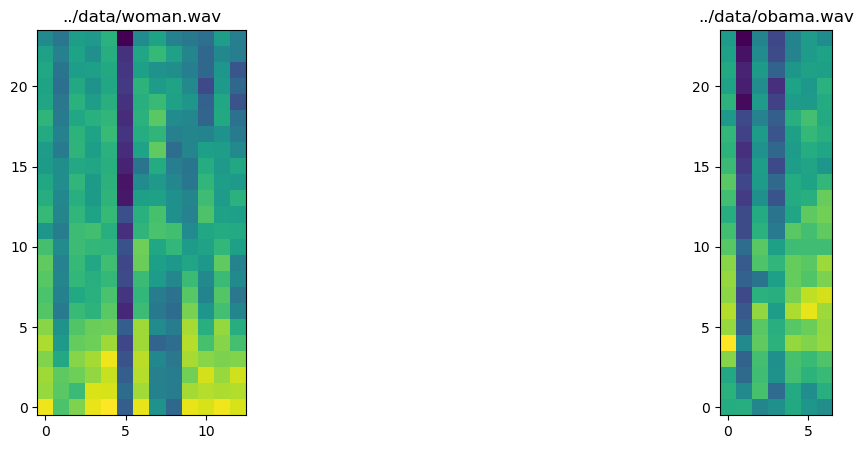

In [13]:
# plot new and previous means
_, ax = plt.subplots(ncols=length(sound_files), figsize=(15,5))
for k = 1:length(sound_files)
    ax[k].imshow(hcat([params[k]["mu_m_"*string(ki)] for ki=1:nr_clusters[k]]...), origin="lower")
    ax[k].set_title(sound_files[k])
end

## Perform source separation

In [14]:
function convert_parameters(params)
    params_new = Dict()
    for k=1:length(params)
        for ki = 1:nr_clusters[k]
            params_new[pad(pad(:μ_m,ki),k)] = params[k]["mu_m_"*string(ki)]
            params_new[pad(pad(:nu_w,ki),k)] = params[k]["nu_w_"*string(ki)]
            params_new[pad(pad(:V_w,ki),k)] = params[k]["V_w_"*string(ki)]
        end
        params_new[pad(:α_π,k)] = params[k]["alpha_pi"]
    end
    return params_new
end
;

In [15]:
function observation_model(k, nr_clusters, nr_freqs, bufsize)
    
    # create factor graph
    fg = FactorGraph()
        
    # create models and combine
    for ki = 1:k
        
        # create signal model
        model = signal_model(ki, nr_clusters[ki], nr_freqs, bufsize)
        eval(model)
        
    end
    @RV xtot = sum([vars[pad(:x, ki)] for ki=1:k])
    
    # add observation noise
    @RV y ~ GaussianMeanVariance(xtot, placeholder(:Σ_meas, dims=(bufsize,bufsize)))
    
    # create output samples
    placeholder(y, :y, dims=(bufsize,))
        
    q_ids = vcat([pad(:Π,ki) for ki=1:k],
                 expand([expand([[pad(pad(:M,ki),kii), pad(pad(:W,ki),kii)] for ki=1:(nr_clusters[kii])]) for kii=1:k]),
                 [pad(:Z,ki) for ki=1:k],
                 [pad(:Ξ,ki) for ki=1:k],
                 :Xc) # this variable is deterministically linked to all other signals. 

    q_i = vcat([vars[pad(:π,ki)] for ki=1:k],
               expand([expand([[vars[pad(pad(:m,ki),kii)], vars[pad(pad(:w,ki),kii)]] for ki=1:(nr_clusters[kii])]) for kii=1:k]),
               [vars[pad(:z,ki)] for ki=1:k],
               [vars[pad(:ξ,ki)] for ki=1:k],
               [[vars[pad(:Xc,ki)] for ki=1:k]])
    
    q = ForneyLab.PosteriorFactorization(q_i..., ids=q_ids)
    
    return fg, q
    
end
;

In [16]:
signal_s = [ymix[(ki-1)*stepsize_sep+1:(ki-1)*stepsize_sep+bufsize] for ki = 1:nr_samples_sep];
t_s = [t_sep[(ki-1)*stepsize_sep+1:(ki-1)*stepsize_sep+bufsize] for ki = 1:nr_samples_sep];
;

In [17]:
# convert parameters
paramsc = convert_parameters(params)

# load graph
fg, q = observation_model(length(sound_files), nr_clusters, nr_freqs, bufsize)

# create algorithm
algo = variationalAlgorithm(q)
source_code = compatibility_fix(algorithmSourceCode(algo))
eval(Meta.parse(source_code))

# specify priors
#priors = load_priors(1:length(sound_files), AR_order, mode="separation")

# specify hyperparameters
hyper = Dict(:Σ_meas => Σ_meas_sep*Ic(bufsize))
hyper = merge(hyper, paramsc)

# create dictionary for to inferred values
vals = Dict()

# separated signals
μ_separated = Array{Array{Array{Float64,1},1},1}(undef, length(sound_files))
Σ_separated = Array{Array{Array{Float64,2},1},1}(undef, length(sound_files))
for k = 1:length(sound_files)
    μ_separated[k] = Array{Array{Float64,1},1}(undef, length(signal_s))
    Σ_separated[k] = Array{Array{Float64,2},1}(undef, length(signal_s))
end
p = Progress(length(signal_s))
# loop through signal
for n = 1:length(signal_s)
       
    # fill data dictionary
    data = merge( hyper, vals, Dict(:y => signal_s[n]))
    for ki = 1:length(sound_files)
        data[pad(:C,ki)] = 1/bufsize*hcat(cos.(2*pi*freqs*t_s[n]')', sin.(2*pi*freqs*t_s[n]')')
        data[pad(:p_z,ki)] = exp.(ForneyLab.digamma.(data[pad(:α_π,ki)]) .- ForneyLab.digamma.(sum(data[pad(:α_π,ki)]))) ./ sum(exp.(ForneyLab.digamma.(data[pad(:α_π,ki)]) .- ForneyLab.digamma.(sum(data[pad(:α_π,ki)]))))
    end
    
    # specify marginals
    marginals = load_marginals(1:length(sound_files), nr_clusters, nr_freqs, data, zeros(size(zmix)), n, mode="separation")

    # perform updates
    for _ = 1:iterations

        # perform inference
        Base.invokelatest(stepXc!, data, marginals)
        for ki = 1:length(sound_files)
            Base.invokelatest(getfield(Main, Symbol("stepΞ_"*string(ki,pad=2)*"!")), data, marginals)
        end
        for ki = 1:length(sound_files)
            Base.invokelatest(getfield(Main, Symbol("stepZ_"*string(ki,pad=2)*"!")), data, marginals)
        end
    end
    
    # get separated signals
    for ki = 1:length(sound_files)
        # complex to real
        μ_cx = ForneyLab.unsafeMean(marginals[pad(:vars_Xc,ki)])
        Γ_cx = ForneyLab.unsafeCov(marginals[pad(:vars_Xc,ki)])
        μ_rx = vcat(real.(μ_cx), imag.(μ_cx))
        V_rx = vcat(hcat(0.5*(real(Γ_cx)), zeros(size(Γ_cx))), hcat(zeros(size(Γ_cx)), 0.5*(real(Γ_cx))))

        C = 1/bufsize*hcat(cos.(2*pi*freqs*t_s[n]')', sin.(2*pi*freqs*t_s[n]')')

        μ_separated[ki][n] = C*μ_rx
        Σ_separated[ki][n] = C*V_rx*C'
    end
    next!(p)
end    

Progress: 100%|█████████████████████████████████████████| Time: 0:03:18


In [18]:
# process predictions
μ_predicted = Array{Array{Float64,1},1}(undef, length(sound_files))
σ_predicted = Array{Array{Float64,1},1}(undef, length(sound_files))
for k = 1:length(sound_files)
    μ_predicted[k] = expand(μ_separated[k])
    σ_predicted[k] = expand([sqrt.(diag(Σ_separated[k][ki])) for ki = 1:length(Σ_separated[k])])
end

## Analyze results

In [30]:
audioplayers(signal_sep..., ymix, fs=fs_desired)
audioplayers(μ_predicted..., fs=fs_desired)

<source src="data:audio/wav;base64,UklGRjxxAgBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQBxAgAm3h2+WAJYvlyTF74sKAC+8N2xveKNLbxBOr89feYtPldyhD5GQK0+7XC/PhNYtD4KNq4+rtBZPrC67zxyTTi9AMkYvYJKIb4lApO+4c90vm4j3L1IqY29gQ54vZSgC7oas409XzuKPR0zzzwlzsi8HYuavU+Dvr2/Nvq9KdwvviG+VL6B/i2+QgjzvfgRv70spn+9D8g0PWqcLj5ZWoA+9FmaPna/uT7Isb8+kve3PtBWdj7UNW49UHUgva7/Hb3QrRe+rwCXvjcijr6jlQ6+wjmTvUoysL2JuBS9ZuJxPYADtT3ZzVo9Ok2UPMHzyryQHJC9fenhvXIsFb5OBEq+WL1Evk9OGb7rBuS9ttJ/veCobD1egEs+YhePPpoqqD4dcsc+HbTRPp1eoT6dUd49PLBKPLQ1HjkUWOG95/OavoqSpr5akEW+ZFz6vbPoE75949C9FGQbPVc7AT7mYro9ranvPOFBoTwYmxw9uobLvFnSC76VFUS+5+YrvrPcGb6jSBq+j6j4vR273rshxQk+0sdwPg+ijj5lv6s+RB3LPp96uT7xSUI+7+OmPFEzzDsMRvC8y7BcvjLVtL78Q4e+af4hvsRsJb47+SK+N3JVvb4jSD2e9p09/D5dPaOzpTy86MU7C9i2PGhnzLy4Cwe+qQccvnphl71BIyG9UEwuveZmkj3Iz4I+9fusPuXnrD7jCa8+cK5pPkknzj19XpA9ICBKvMFKbL4sDZ6+PWZavo7XOr73PGy+dGIxvgvurbxlyJA9/VrFPfFG+T2cVMU9nCWAPTvXiT3zi9k8g1zwvXnpUb7b6Bm+ZhoIvgYPVr6AkUS+leZPvYQ1QT2j/4U9ioICPt8sXT47aIM+UVJkPvH/Oj5oIRM+3k/EPREWAT3NmSK9Uk1yvU+Zgb2KSvW9Q98svqKS+b0E/qm9uLvRvZNjxL06CY688yd5PBjKwLyn10m93ykWvbBiu7wpZr28Mv5uvNcmljwnp8M9LhlAPgI7gT4LFpU+FO6yPgk+nT63/b89RO9wvCGPDT0Psna9Asucvt/lor5cwRC+g2YCviPFZr4GwwW+r7WOPehlDD4C4tA9CrcDPouPOj4LbTU+J9LnPeD1qjweJF29o5m7vXQY1L0N1yS+8P9LvgoGHr7OFpS9UZZ3vbDJXL0vs0I5yGaCPSH7ej3JuxY95QUWPXIiGz0/Fg48t+InvYocUb3J5A69kJ/pvP3kIb0l9Re9NCnavJleDbvMzRQ8Kt5kO+WU0bv/v/Y7i85KPIHSELz4jgq9E8rYvC+QC7zGg6O82kA3vErSlDyB5BA9kokIPWwXPT33eWw9OweFPetYWD2RzhE9ZirGPBZ+mzwPDDo7Z8AJvYLkQ7204Du92DlnveEnnr0utoa9/Q5RvT31UL0kA0q9QIL1vDAzobzzM5S8EoDSu/8Y+DubFnc8Zxn2PEShbD25s4Q9i+aJPbFpuD2m9tQ9MpS2PWpIjT1pVEU9R9kFPdJeUbsV+C69UBWxveov6L3CPPW9eDb1vXjqCr7DMQS+5gS5vd5ah70KU1q9qQLrvFmAEjoFO5U8F04WPcr6RD1z7nU9/0/CPU0JCz6G1yI+SgM7Pk5oQD7zuho+pYG4Pa1oiD3ehoO7cmncvTW3IL6DcRy+G7g9vqorbb7aQ0i+AjQFvqwI4r1xA8294RwkvdNlijwunwc9ZXlBPUF5oT1Th9k9D+XrPZ6dDD7rCjc+ajxePtoGcD76QS0+2eRTPXzW/zzMtVc95blbvaH4Rr72ohe+b0WNvVrsGb7W0Eu+u92pva7rtzsqfBu9RDSWvFH3pT0i09c9AdtkPWNvaD2AeKE99OADPRanAb078BS9XWkdvV/ror34+sm9oh6yvZcwob0LuZC9wkZZvUwN7rxGxES81OFpvA85OLwn4IU6sAOIPIIHeTsGgii82qKQO3VBFDwirSm8Ii4bvES+9zvMPcK7ZO+avHBhZ7yv7Be8sZYZvLcXoLtEKYU7FufXOyp1ETxvxyg8/3FdPOjDDD0Lxxg9JiC6PHcAjjz5zgA9c+vlPCLCfTwGkLI8zgbDPHW+ADylOCa6UEUXOWbb5bsBcg68Q7gWvOz1BbwzVQm8eW8JvB1eN7p7ZSW7VXoPO8bL9juscq07b5FTPFxYuzzyqUQ8q99qPGFH8DwLoKM8UzOtOyJ0gjyqL+k8SYmGPB+VBjwPn+k73dMiutiiGDzrUYk8A3IPvKwdLbw3k1Q8r7crPIW+BbyaxSU7Y1a5O38LgTrgKRs8ksfSO0ZLJjpFjOc7/IGFPNUgDzywbv86eu1kPASc+jsH/Kc85kY3PNAYOzrIffo8eQSBPB61FTyZ7tI8jfhxO77EWTr9QME80SY9PHTWj7yZoce7CojkONY0crx1yRm7BX+yOoldNryldiQ8KKjKu7z+67wluYQ8OFn6PJ/8j7wrPx+9/qpRPI1WED3XmvC8Xcu/vH80Gj1vu6S8EOMAvQa8IT1AySO7HWBuvW20XztRZKI86oARvQ+3JL0fHqG7G1AyvB3ZzLyRtvO7SlHdvIsUbLx7+LA8DCOMvFAnQ73Hvoc8n3gxPIFyEr3Kz0m89ozMO3k1MrxEM8C8YeCYu+K3NTtSOdO8tSewvKA30LtDAuG7TLDMvErbvLzUsPe77GZfvDToMLynqu27Dj0MuxXI47onBFe7Hl9euwGHajqXxng7PKfIu9RkjLudMV+6CAaButMrXLvWSRW8TcWku8iRtrtSOwW5uP+9OszEJDoph7I5epzPOxdIHTpn9KW7ovsQu/l5zrsuKia8yiEqvBATCby+/ya8g7CBvHTWN7wdI+K7y//EusikeruPyDo62QooPIXaGzyj4os7we/LO/d2Bzxlcmo73v04O047PjvYlzc30iqGOmTLB7lz2om6khy7uo7x0bp0ZRE7iyfZOYfJsrvIqLu7zyDzu5eKBryZbwi8+OTyu5Zv77rP2lM6+tuvO07X8TrT3XE6y+vxO1WnCjw9sjI7R18iulemuDt8yMM7NGzcuv1pk7mDL8U7HN+/O6a8DDpH1kw6CCrGO+9Nyzv+Mwc8n6saPAmTRjwatCA8kWQ4PKVIFzzxuvI7btwPPHnJrTtuphg73m7KOx28xjsazTE8MKcaPBhc2jv65gA8vQ38O+jo2Dvpqb47OmoNPHMaPjywXtI7ZVihOxGVEjyp5u877pAgPG7lfTwh21I8dOsQPCfDITzFOiA8zYEwOxRszjt9C386tJKiuw8W4LtpatC7NrF7u548uruQUXQ5Zh6OO+rY4TqHlHE6XEkwOwoe2jq4gm27fR/Tu2biDbzZdCe8r6slvCTva7wbFYy8h+WGvBoXdLxpv5m8OfRwvOCIUbzmpYC865yDvHnQgryJJYW8F1alvDXwmLwESKy844asvEAUp7z6eZu8PMqpvE7Pn7xd6jO8OoqAvF66eLy1zVG8qShEvCO6RbzH6Ze8v6SavF3coryltoa8X7x5vG5Hf7xI2Xm8s2ZovLA9frw7jI68q0aKvJZqPbwitFO8nPB2vACWO7z2tgu8huMlvIJt0LtwIJq7RFsmvGfnFLyTNKa73dR/u8WcfbuASaG77CfFuzxvg7i3K9a61vLRuet8wTpeuIg6FhtwO/eHBjsq55s6Jw6OO9Hn4ro1HY67N++8OocKKjqo7wo77+ScOi3R0jus3687jEiIOy1cDTxzpSM8VcUOPBitdjw/wzc8jLcxPHSvITyoDBI8nN41PG5G+jsLvUU8Cw4WPIyL5jsj9fk7TstKPAAVPTz3XBY80RBhPNCTYDxlJwg8ztUtPH+sXDxyEH081kqCPJotdjwV9WI8LZOBPHfYmDwNrmI8o6wxPOOBZDzxw

<source src="data:audio/wav;base64,UklGRjxxAgBXQVZFZm10ICgAAAD+/wEAQB8AAAB9AAAEACAAFgAgAAAAAAADAAAAAAAQAIAAAKoAOJtxZGF0YQBxAgBqyH6+NVeZvhh1kL5kWFy+d/DQvTOh1TtgWxw+sCOFPpq9tj6zGtY+O+vJPttrpz71n4U+X1soPholBDz9e6G9BDTovbenL76Mwlu+jlYsvhjs8r2xM+C95sSnvWSwQ70emRa94BSfvb956b3c3hW+wLs1vtlSaL4hrHi+CDpavk/qTL6zwzK+p2rsvV0kFL2QvaG7s+6EPVnc5D18XEQ+KEBvPvIDkT5vh5M+BbGcPqJTiz5a0ys+Yrq7PXJYiDznMPC9Fe12vkLE9r1HuX69N8YtvftFQr14T2G87jO2PaSzvj2DIbo9JpLaPUbcij34B5q83Gj8vZ7QMr70K4u+wauWvvBtmr4lXVq+fVP5vas/wDwVDiA+/xCePr43yj7RRNk+zkbOPlc5qT4Eyz8+Tp/uPMebkb10sUC+qB11vjEbbL74Oiu++tC4vfVJcDsA5b093GIQPgkdLz5d2BM+UyjgPdNILj12vcC7tUSLvYaHo71KZM690NjYvWbTfr31RWe9YcqIvZZUX719toy8XVtVPgEyVT4YTjg+3XIhPrVFHD5NBs49R5zXPBAlorxsEXi9FKURvokvRr72GkS+n4JEvrTbPr7dUhG+uESIvZGIqryJ1Ng8+PWSPYmUsj0W14A9CmQkPUeoTTuLlSi9A/iVvYYgcr09Tv+8fYOBPPKP1T3enUg+n096PouIjD5x1pc+IUB2PsjLBz6KHS09rndwvXiWUL40RJi+TNWivr7qqr5fj6u+ArCEvs1aG74mjqi97uj0u88Dvj1Fkxk+G9EsPhryOz7sQQa+XH4UvoWvOL68Fy++E9QRviVkC76rZLG9kO6avOucRT0HMeI9RnE3PlH1Zz7m13E+l799PrOfWj7Hqyk+EVLiPeEGZD1/wzu8KZlFvVxPpr0V19a90WbrvYFZ5716agK+6vMIvgVSEb6HWiO+P9onvkudLr5ztB6+tA7wvQnnlL0bzVS8cxN5PbmsBj5ZMTY+3sBmPm05fj4PB2s+rahKPlTIND6BCNI9Vl0lPTuyjzzdew+9boy0vfAMur3Kb8O9QRMcviiiXbxzb8E7qvIcPQJZfT3GgJM9v7/ZPWzz/j1/+e092FvIPYl4jD2yDoE8HbJEvbeb173Vvh2+g55CvshUUL7pTT6+qtsavn33x70O8DC934WMPP8UhT0DWbk9FlTAPfU5vD3Tn3I9STQBPcPOLLuxLMm89E0ZvSG7CL2kQ5C8kQchuxuO1zyf9kk9cThrPeygeD0pYlQ9HggkPYUUgTyFCze63tJhvChen7xDRN68w/LpvO7rerzBMmC8cdyevBWMbLw1naA7p7ZkPZF4TD1RLCE8XP9OvE45WL2MYWm9DMybvSPWoL0yAIu9/LdhvYXfQb2tsv68KoFCvEuYh7ztyFG7gnU/vHPLgbj8V767kNKSPMc93DybrVI9ytOcPcbC2z06JO49jv8JPkjC9z2qYQE+UKLNPT5Nrj17G2s9KzomPaMl9TsDs4m8REdBvU7Hib1yHcm9GXPcvX8bBL6Qlga+PY4DvkZh8L3lKcq9da6SvZEOC73Fguy7/igePfvmiD2H77s94iCpPQbj8D1bcgI+MIXvPXX67j371LY9NW1kPYWzTDyD4GW8/gJkvT2Fyr1//OO90QwFvnOvBb5RLwy+kL/zva36170fg5i9U5UsvdSTO7xlF9g8K9KNPZuqyj2Fy+o9YVYJPnzBEz6gZwM++o/QPW3bpz0QWT89JJ06vF+ZaL2YrqG9PXvmvZ3ZHL7yThC+sWHzvQqu9r3VkN69NR9avcCL7bxm8ba8GwUBvHACBT1v7/48s8nlPDMEUj3B9Ik9wymSPUmwmj0YJeU9aAvhPfOlIbx5EoS85sYVvN6JmbrQb0e6/t2JOzU/EDxHbnI8w2tGPB3zEjzQ7xI7LvHPurgkSbxvtp28TBLfvF9ZzrzadxC9kRYDvYQn8rzNENi8UWHHvFPKh7xVJTO8iQkqupBmyTsMHlI8+NiiPCnobjwUWtE8YxSLPCk96zzoWtc8LmjlPC8z9zy3cwA9af4IPXA0pDydx8M8JtSDPG8FVTxoots79sPEOxNWKjrTNZa7mSkNvIdscbwHU4u8k5KuvDSHrrwZ3dG8EuI+vHM0S7womr68jGfYvJkD27zKS8G8suXLvAYSYrwOAfe7w0Eou257MjwKDW08bO21PB0dmjwK7sY8h9FiPK5xhjyPx248PBOgO/qoZDsJxQU8x00zPC/NbTsp1yg89+9RPL+NSjy464c8fi6lPKNEkjyJ45Y82yVQPIL8nDvUMoG7la9HvPcs3bwkROW8Y28BvRpzEr1EnP28vfK1vGODmLzjyy28agWNOhpK8DsQ4Zo8PoCQPKSHqTx9NYs8Zhl3PIkMXjsFrZq8DUGyvE/gd7yzt6a7dZIMvOtX57vwg0s8DdgCPQXxrTxHGYw81YkvPZhMNT1Kip88/dG/PNugQz00HYs8G6tAOh6snjzKPqY7aIvevPZu8Lwc0My82s42vcmrQb1vij29pNQsvfFTGr0F2g69XGYkvb5IvLz5Eaq55ipxvGlHsrvVDLo8MW32PGpexjsJ4aU8Bj0VPev1vDwQB5A8GsbLPEBeBT3oD0E89kH9Owq3PDxpDZk7WC5kvOLGlbwqjzC8pfJrvOs8FzyIYo08FSXcPIhAEj29aAM9yIrUPKXTeTzZgcw7V5ErvNEYvLwxQwy9/70cvXfxKr1RFSi9KbwXvQUc07ygHUS8UL4DvGKyZjzrUJA8/iDuPHx1tzyyhKU8pGSePM05ATyH/P87NL5pugCCGTtmR026e0c7O77g5zumfzk8Y/ltPHU6pDytj/M8pDsFPabeAz1euOs8ygfQPAMtXDzj1NS431BFvPFv0bwB+wO9YYEvvWgvKr3BnxW9wbr6vPBrr7wDQDa8rs1CvMYjC7zWRhG8NSxqvJz3YLxWuhS8Yn0SvIxcR7zLgf677Ryduynsi7vj8+e4uZnkOoSE7jsQjjk8PzqDPCXGfDybapk8OjuePEG9kTyz0pw8jcikPAlUgzxJG0c8kIo/PLVgIzv6xQu7pNEFvHKCfrwcGpq8ydC8vJt/0bzqNd+8cZbEvM7ftrwQ6Lm8Ed4ivNmEoLuzAng5cWiuO0ZubjzMPGk8lRSVPP08gTxtvnM8jeNJPG6MRDx7PsE7BTqXOtchojvlYk08adBhPNk2UzziKns8ptyPPA3xaTyoVVk8juNBPMDrCDz2h7873hXFO8kNdroFxz67uNLbu4aTLrxaeWa8YfljvNbQgLzGW4q8SFlJvG7FWrzClV+8dk8yvE/xVLsKxAC8LZXvOonMfjrWx/Y7QnDZO6EWCDztysU7sFvIO+6mIzzO+bI71hIKPNzHvjtM9Hc77jByOnVjyLohK8G75FgivIXRCryE8CW8ltwVvGVj4rueHXi7qUKfuzbErbmgXVo796M3uwrq/TuKTvg6/jGsuzjWXLyo+oi8CY6MvNJbs7zf7p28aepuvK0WXrxWZQK8MynluaARfDuQ5wE8Yl7RO1prATy4DZs7b9SjOzy6MjrZnmi7BAdPut7Hz7o9Z1U691gPOwtBoTvbJ+U7Qo4xPC3WaDyiP3c8PeGMPEBHiDxDbGM8plXqO5AS7jpWwM67andgvNBYjLw50ba83Pa7vIwcnbzm62e8jQ9KvPIFgbuiy4o7BodCPPXjhDxCqJ48yHKtPNXhsDzHg4I8krMSvH0IPrxjtkG8eO4SvE2/HLy8fty7iXoau62obztdufE7RoUWPKIsUDy3fk08U89xPJviXjzwyi08b1MbPMy6BTzRF9o7CA73t43Kg7kTouC7ybUIvO72G7w76zq8n+lhvPJ9Nbybv

In [29]:
# save mixture sound
wavwrite(ymix, folder_audio*"/GSMM_mixture"*join(["_"*split(split(sound_files[k],"/")[end], ".")[1] for k=1:length(sound_files)])*".wav", Fs=fs_desired)

# save sound files
for k = 1:length(sound_files)
    filename = folder_audio*"/GSMM_true_"*split(split(sound_files[k],"/")[end], ".")[1]*".wav"
    wavwrite(signal_sep[k], filename, Fs=fs_desired)
    filename = folder_audio*"/GSMM_predicted_"*split(split(sound_files[k],"/")[end], ".")[1]*"_"*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".wav"
    wavwrite(μ_predicted[k], filename, Fs=fs_desired)
end

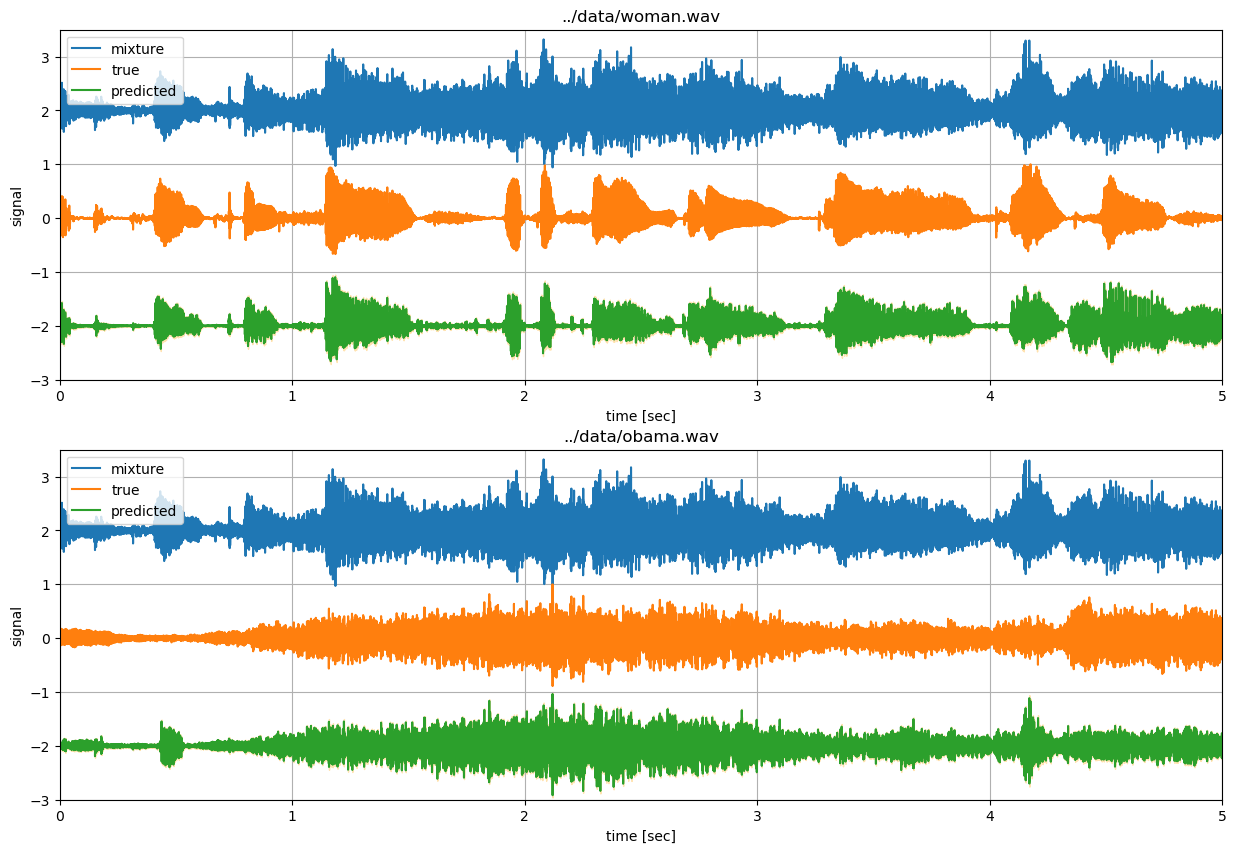

In [20]:
# create axes for subplots
_, ax = plt.subplots(ncols=1, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot time-domain signal
    ax[k].plot(t_sep, ymix.+2, label="mixture")
    ax[k].plot(t_sep, signal_sep[k], label="true")
    ax[k].plot(t_sep, μ_predicted[k].-2, label="predicted")
    ax[k].fill_between(t_sep, μ_predicted[k].-2 .- σ_predicted[k], μ_predicted[k].-2 .+ σ_predicted[k], alpha=0.3, color="orange")
    ax[k].set_xlim([0, duration_sep]), ax[k].set_ylim(-3, 3.5), ax[k].set_xlabel("time [sec]"), ax[k].set_ylabel("signal"), ax[k].grid(), ax[k].set_title(sound_files[k]), ax[k].legend()
    
end

# save figure
filename_figures1 = folder_figures*"/GSMM_time1_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".png"
plt.savefig(filename_figures1)

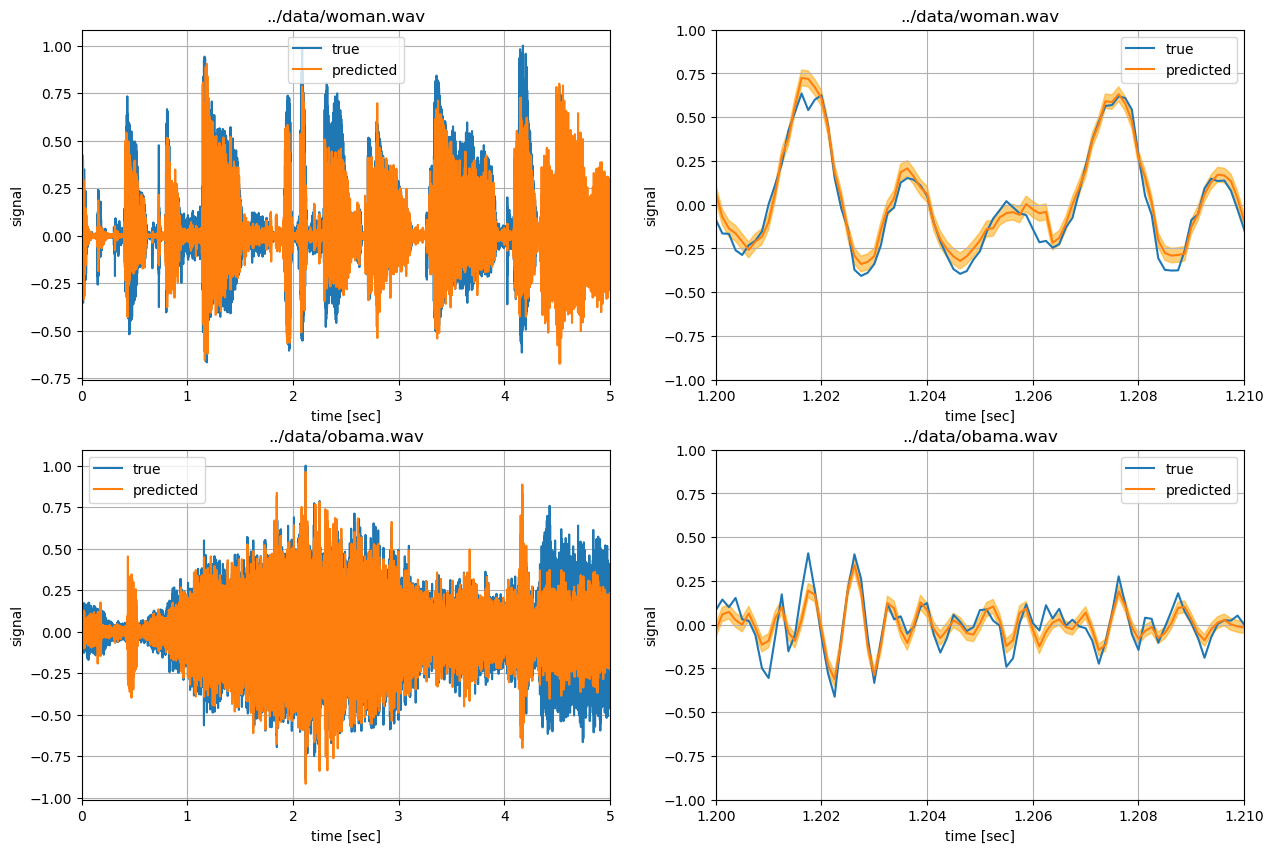

In [21]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot time-domain signal
    ax[k,1].plot(t_sep, signal_sep[k], label="true")
    ax[k,1].plot(t_sep, μ_predicted[k], label="predicted")
    ax[k,2].fill_between(t_sep, μ_predicted[k] .- σ_predicted[k], μ_predicted[k] .+ σ_predicted[k], alpha=0.3, color="orange")
    ax[k,1].set_xlim([0, duration_sep]), ax[k,1].set_xlabel("time [sec]"), ax[k,1].set_ylabel("signal"), ax[k,1].grid(), ax[k,1].set_title(sound_files[k]), ax[k,1].legend()
    
    # plot zoomed-in version of signal
    ax[k,2].plot(t_sep, signal_sep[k], label="true")
    ax[k,2].plot(t_sep, μ_predicted[k], label="predicted")
    ax[k,2].fill_between(t_sep, μ_predicted[k] .- σ_predicted[k], μ_predicted[k] .+ σ_predicted[k], alpha=0.3, color="orange")
    ax[k,2].set_xlim([1.2, 1.21]), ax[k,2].set_ylim(-1,1), ax[k,2].set_xlabel("time [sec]"), ax[k,2].set_ylabel("signal"), ax[k,2].grid(), ax[k,2].set_title(sound_files[k]), ax[k,2].legend()

end

# save figure
filename_figures2 = folder_figures*"/GSMM_time2_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".png"
plt.savefig(filename_figures2)

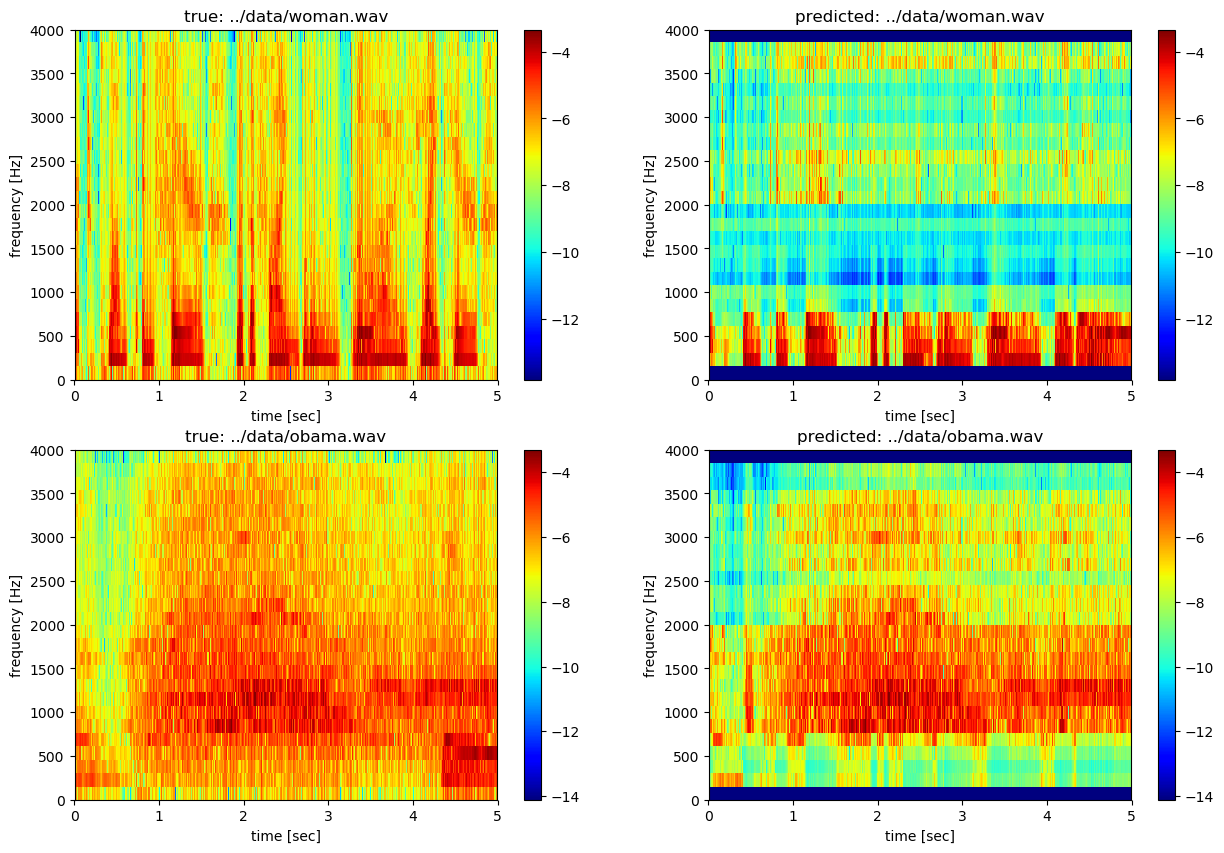

In [22]:
# create axes for subplots
_, ax = plt.subplots(ncols=2, nrows=length(sound_files), figsize=(15, 5*(length(sound_files))))

# loop through rows and fill them
for k = 1:length(sound_files)
    
    # plot true spectrogram
    plot_spectrogram(spectrogram(expand(signal_sep[k]), bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=ax[k,1], colorbar=true)
    ax[k,1].set_title("true: "*sound_files[k])
    vrange = ax[k,1].get_images()[1].get_clim()
    
    # plot predicted spectrogram
    plot_spectrogram(spectrogram(μ_predicted[k], bufsize, bufsize-stepsize_sep, fs=fs_desired), fs_desired, ax=ax[k,2], colorbar=true)
    ax[k,2].set_title("predicted: "*sound_files[k])
    ax[k,2].get_images()[1].set_clim(vrange)

end

# save figure
filename_figures3 = folder_figures*"/GSMM_"*join([split(split(sound_files[k],"/")[end], ".")[1]*"_" for k=1:length(sound_files)])*join([string(nr_clusters[ki], pad=2)*"_" for ki=1:length(nr_clusters)])*string(nr_freqs, pad=2)*"_"*@sprintf("%.1E", Σ_meas_train)*"_"*@sprintf("%.1E", Σ_meas_sep)*".png"
plt.savefig(filename_figures3)

In [23]:
using Distributions;
for k = 1:length(sound_files)
    
    MSE = mean(abs2.(signal_sep[k] - μ_predicted[k]))
    MAE = mean(abs.(signal_sep[k] - μ_predicted[k]))
    BME = mean([logpdf(Normal(μ_predicted[k][ki], σ_predicted[k][ki]), signal_sep[k][ki]) for ki = 1:length(signal_sep[k])])

    println("signal "*string(k)*": "*sound_files[k])
    println("--MSE: ",MSE)
    println("--MAE: ",MAE)
    println("--BME: ",BME)
end

signal 1: ../data/woman.wav


--MSE: 0.008503596783780642
--MAE: 0.05828544776962028
--BME: -0.5768537129333434
signal 2: ../data/obama.wav
--MSE: 0.00909554558161756
--MAE: 0.06236094344264952
--BME: -1.957340607614756
